In [1]:
import os
import torch
import torchvision
# import torchvision.transforms as transforms
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.progress import track
from skimage import io, transform


seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

batch_size = 64
img_size = 180

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print('Running on GPU: {}.'.format(torch.cuda.get_device_name()))
else:
    print('Running on CPU.')

In [2]:
def load_data_first_time(img_size, desired=None):
    preset_mean = [0.0, 0.0, 0.0]
    preset_std = [0.0, 0.0, 0.0]

    transform = transforms.Compose(
        [
         transforms.Resize(img_size),
         transforms.CenterCrop(img_size),
#          transforms.Grayscale(),
         transforms.ToTensor()
         ])
#     transforms.Normalize(preset_mean, preset_std)

    imageDataset = torchvision.datasets.ImageFolder(root='./alldata', transform=transform)
    
    random.shuffle(imageDataset.imgs)


    print ("Sample Images:", imageDataset.imgs[:5])
    print ("Labels:", imageDataset.class_to_idx)

    num_classes = len(imageDataset.classes)

    print ("Number of images:",len(imageDataset))
    
    return imageDataset




In [3]:


def getMeanStd(imageDataset):
    nimages = len(imageDataset)
    mean = 0.
    std = 0.
    
    sss = np.empty((3,))
#     print (np.array(imageDataset[5][0]).shape)
#     immg = np.array(imageDataset[5][0])#.reshape(img_size, img_size, 3)
#     print (imageDataset.imgs[5], immg.shape)
#     depth, rows, cols = immg.shape
#     immg = immg.reshape(rows, cols, depth)
#     plt.imshow(immg, cmap="gray")
#     plt.show()
    
#     from PIL import Image
#     im = Image.open(imageDataset.imgs[5][0])
#     display(im)

#     return
    
    count  =0
    for img, _ in imageDataset:
#         count +=1
#         if count%100==0:
#             print (count, sss.shape)
#         if count%1000 ==0:
#             print (sss.std(0))
            
        arr = np.array(img)
#         print (arr.shape)
#         print (arr.mean(1).mean(1))
#         mean += arr.mean(1).mean(1) #arr.mean(1).sum(1) # this one
        mean += images.mean(2).sum(0)
#         s = arr.reshape(3, -1).std(1)
        
#         sss = np.vstack((sss, arr.reshape(-1, 3)))
#         sss.append(arr.reshape(-1, 3))
#         print (np.multiply(s,s).shape)
#         std += np.multiply(s,s)
        #std += arr.std(1).sum(1)
        
    mean /= nimages
#     std /= nimages
#     print (std.shape, "sdfdsf")
#     std = np.sqrt(std)
    
#     print ("loop complete")
    
#     print ("STD:", sss.std(0))

    return {"mean": mean,"std": std}

imageDataset = load_data_first_time(img_size)
classes = imageDataset.classes

# getMeanStd(imageDataset)



In [4]:
loader = torch.utils.data.DataLoader(imageDataset,
                         batch_size=32,
                         shuffle=False)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*180*180))

In [70]:
mean, std

(tensor([0.3830, 0.2347, 0.2191], device='cpu'),
 tensor([0.2029, 0.1551, 0.1607], device='cpu'))

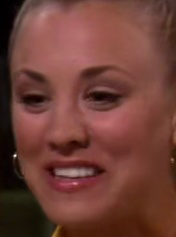

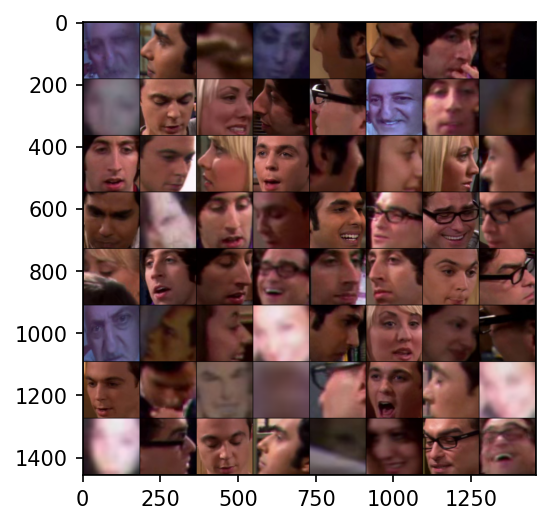

In [92]:
from PIL import Image
im = Image.open('./alldata/Penny/face458_c44b8e1e-2a9e-11eb-aff2-002432182720.jpg')
display(im)

def imshow(img, normalize=True):
    nimg = img.numpy()
    if normalize:
        nimg[0, :, :] += 0.3831
        nimg[1, :, :] += 0.2346
        nimg[2, :, :] += 0.2189
    
    plt.imshow(np.transpose(nimg, (1, 2, 0)))
    plt.show()


# get some random training images

trainloader = torch.utils.data.DataLoader(imageDataset, batch_size=batch_size,shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images), False)
# print labels
# print(' '.join('%5s' % classes[labels[j]][0] for j in range(batch_size)))

In [6]:
def load_fulldata(img_size, desired=None):
#     means = [22.977926, 14.072051, 13.135243]
#     stds = [6.766082 , 4.9459076, 4.655467] 
    
    means = [0.3831, 0.2346, 0.2189] # [68.95092 , 42.220562, 39.40766 ] # [22.977901, 14.072001, 13.135235]
    stds =  [0.2026, 0.1548, 0.1604] #[12.395633,  9.082816,  8.674709] #[20.493658, 15.029254, 14.170863] # [6.7660933, 4.9459095, 4.655468 ]
#     [0.3830612 , 0.23455817, 0.21893184] #
#     [0.19234892, 0.19233663, 0.19233346] #
#     transform = transforms.Compose([
#         transforms.Resize(img_size),
#         transforms.CenterCrop(img_size),
#         transforms.ToTensor(),
#         transforms.Normalize(means, stds)
#         ])

    transform = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
#             transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ])

    fulldataset = datasets.ImageFolder(root='./alldata', transform = transform)
#     fulldataset = datasets.ImageFolder(root='./sample_data', transform = transform)
    random.shuffle(fulldataset.imgs)
    
    if desired:
        for i in range(len(fulldataset)):
            img , label = fulldataset.imgs[i]
            if label == desired:
                fulldataset.imgs[i] = (img, 1)
            else:
                fulldataset.imgs[i] = (img, 0)
    
    print (fulldataset.imgs[:15])
    
    

    return fulldataset

# fulldataset = load_fulldata(img_size)




In [112]:

def get_loaders(data):
    n = len(data)
    n_train = int(0.7 * n)
    n_valid = int(0.15 * n)
    n_test  = int(0.15 * n)
    
    random.shuffle(data.imgs)

    train_set = torch.utils.data.Subset(data, range(0, n_train))
    valid_set = torch.utils.data.Subset(data, range(n_train, n_train + n_valid))
    test_set  = torch.utils.data.Subset(data, range(n_train + n_valid, n))
    
    print (batch_size)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=True)
    
    return train_loader, valid_loader, test_loader



# len(train_loader), len(valid_loader), len(test_loader)


In [135]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_norm1 = nn.BatchNorm2d(20)
        self.conv_norm2 = nn.BatchNorm2d(20)
        self.conv_norm3 = nn.BatchNorm2d(20)
        self.conv_norm4 = nn.BatchNorm2d(20)
        
        self.conv_norm1.track_running_stats=False
        self.conv_norm2.track_running_stats=False
#         self.conv_norm3.track_running_stats=False
#         self.conv_norm4.track_running_stats=False
        

        self.conv1 = nn.Conv2d(3,  20, 3)
        self.conv2 = nn.Conv2d(20, 20, 3)
#         self.conv3 = nn.Conv2d(20, 20, 3)
#         self.conv4 = nn.Conv2d(20, 20, 3)
        
        self.fc1 = nn.Linear(20*43*43, 400)
        self.fc2 = nn.Linear(400, 7)

        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.conv_norm2(self.conv2(x))))
#         x = self.pool(F.relu(self.conv_norm3(self.conv3(x))))
#         x = self.pool(F.relu(self.conv_norm4(self.conv4(x))))
#         print ("x shape", x.shape)
        x = x.view(-1,20*43*43)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [113]:
def evaluate(model, v, show, loss_fnc, desired=False, sensitivity=False):
    total = 0
    correct = 0
    vloss = 0
    
    ones = torch.ones([batch_size], dtype=torch.long)
    neg_ones = -1 * ones
    twos = ones + 1
    
    TPs = 0.
    FPs = 0.
    FNs = 0.
    
    with torch.no_grad():
        for data in v:
            images, labels = data
            outputs = model(images.type(torch.cuda.FloatTensor))
            labels = labels.type(torch.cuda.LongTensor)

            vloss += loss_fnc(input=outputs.squeeze(), target=labels)
            
            
                
                

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
            
            if sensitivity:
                TPs += (predicted + labels == twos[:len(labels)]).sum().item()
#                 FPs += (predicted - labels == neg_ones).sum().item()
                FNs += (predicted - labels == ones[:len(labels)]).sum().item()

            lookup = classes

            if desired:
                lookup = ["Extra", classes[desired]]

            
            if show:
                for i in range(len(predicted)):
                    if predicted[i] != labels[i]:
                        imshow(images[i])
                        
#                         imshow(torchvision.utils.make_grid(imm))


#                         plt.imshow(torchvision.utils.make_grid(images[i].reshape(180, 180, 3))) #.reshape(60, 60, 3)
#                         plt.show()

                        print (">>>>>>", lookup[predicted[i]])
                        print ("Truth:", lookup[labels[i]])
    
    if sensitivity:
        return TPs/(TPs+FNs), vloss.item()/len(v)
        
    return float(correct)/float(total), vloss.item()/len(v)

In [145]:
fulldataset = load_fulldata(img_size)
train_loader, valid_loader, test_loader = get_loaders(fulldataset)
# print (len(train_loader), len(valid_loader), len(test_loader))

model = Net()
if torch.cuda.is_available():
    model = model.cuda()
    
    
lr = 0.03 # 96.6%
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


# optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fnc = nn.CrossEntropyLoss().cuda()
# loss_fnc = nn.MSELoss().cuda()
epochs = 30


losses = []
vlosses = []
vaccs = []
accs = []
tlosses = []
k=0

from time import time

start = time()
best_vacc = 0

print ("start training")
for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = model(inputs.type(torch.cuda.FloatTensor))
        
        labels = labels.type(torch.cuda.LongTensor)
        loss = loss_fnc(input=outputs.squeeze(), target=labels)
        
        loss.backward()
        optimizer.step()
        
        
    if (epoch)%1 == 0:
        model.eval()
        vacc, vloss = evaluate(model, valid_loader, False, loss_fnc, sensitivity=True)
        model.train()
#         acc, tloss = evaluate(model, train_loader, False, loss_fnc)

#         accs.append(acc)
#         tlosses.append(tloss)
#         vaccs.append(vacc)
#         losses.append(loss)
        vlosses.append(vloss)
        
#         print('[%d, %.1f] loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, tloss, acc*100))
        if vacc > best_vacc:
            best_vacc = vacc
            print('[%d, %.1f] loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, vloss, vacc*100))
        else:
            print('[%d, %.1f] loss: %.4f, acc: %.1f' % (epoch + 1, time()-start, vloss, vacc*100))

print ("Batch size", batch_size)
print('Total Time:', time()-start)

ZeroDivisionError: float division by zero

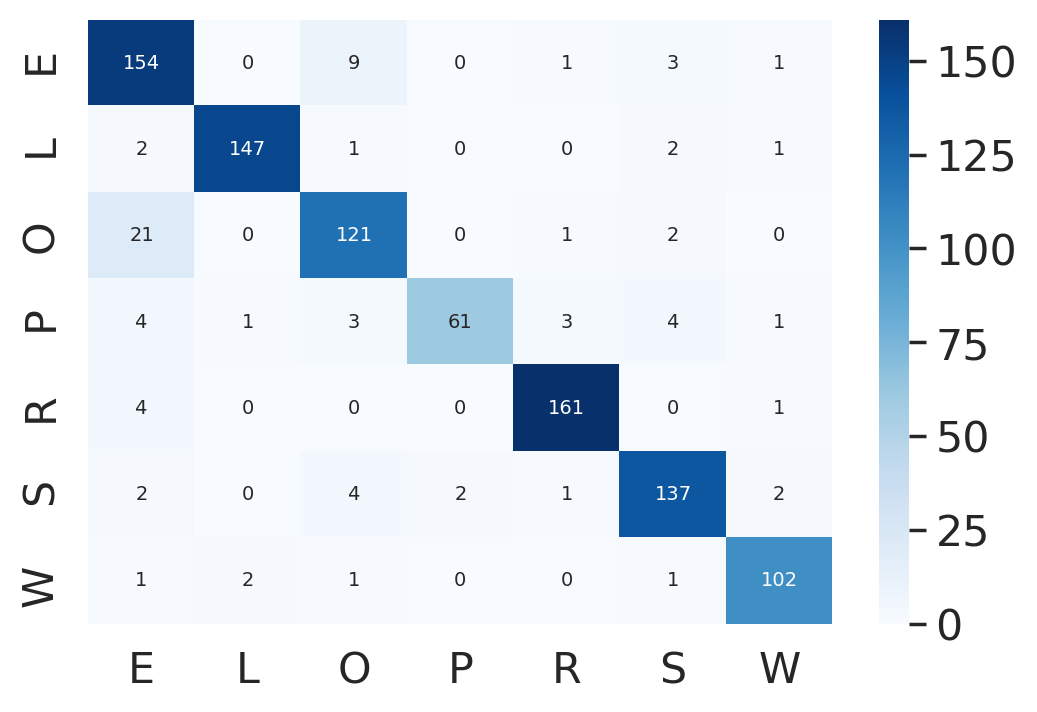

(0.9037267080745341, 0.2964194388616653)

In [137]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for data in test_loader:
        images, labels = data
        
        for i in range(len(labels)):
            y_true.append(labels[i])
        
        outputs = model(images.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred += list(predicted.float())
        
y_true = [int(c) for c in y_true]
y_pred = [int(c) for c in y_pred]

conf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf_matrix, index = [i for i in "ELOPRSW"],
                  columns = [i for i in "ELOPRSW"])


# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 7}, fmt='g', cmap="Blues") # font size
plt.savefig('Confusion.jpg')
plt.show()

evaluate(model, test_loader, False, loss_fnc)
# for a,b in zip(y_pred, y_true):
#     if a != b:
#         print (a,b)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


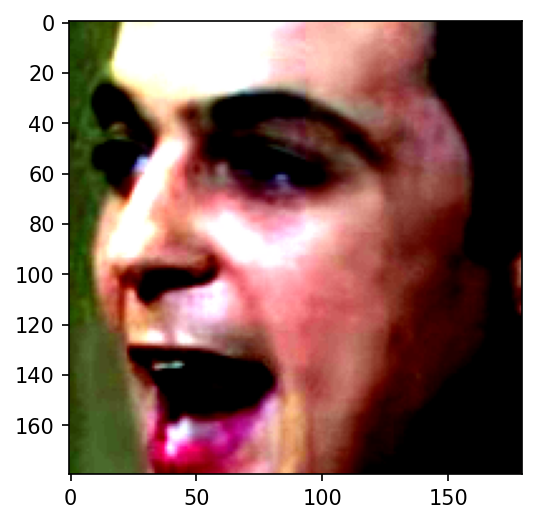

In [114]:
# {'Extra': 0, 'Leonard': 1, 'Other': 2, 'Penny': 3, 'Raj': 4, 'Sheldon': 5, 'Wolowitz': 6}

desired =  4
fulldataset = load_fulldata(img_size, desired)
print (fulldataset)
train_loader, valid_loader, test_loader = get_loaders(fulldataset)
# t,v,q = get_loaders(fulldataset)

# print (len(train_loader), len(valid_loader), len(test_loader))
# print (len(t), len(v), len(q))
d = iter(train_loader)

images, labels = d.next()
# print (labels)
# show images
imm = images[0]# - images[0].min()
# imm[imm < 0] = 0

# print (imm)

# print (fulldataset)
imshow(torchvision.utils.make_grid(imm))

In [115]:
class BinaryNet(nn.Module):
    def __init__(self, hidden=32, conv_num=4):
        super(BinaryNet, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_norm1 = nn.BatchNorm2d(20)
        self.conv_norm2 = nn.BatchNorm2d(20)
        self.conv_norm3 = nn.BatchNorm2d(20)
        self.conv_norm4 = nn.BatchNorm2d(20)
        
        self.conv_norm1.track_running_stats=False
        self.conv_norm2.track_running_stats=False
        self.conv_norm3.track_running_stats=False
        self.conv_norm4.track_running_stats=False
        
#         self.conv1 = nn.Conv2d(3,  20, 3)
#         self.conv2 = nn.Conv2d(20, 20, 3)
#         self.conv3 = nn.Conv2d(20, 20, 3)
#         self.conv4 = nn.Conv2d(20, 20, 3)

        
        self.conv1 = nn.Conv2d(3,  20, 6)
        self.conv2 = nn.Conv2d(20, 20, 4)
        self.conv3 = nn.Conv2d(20, 20, 3)
        self.conv4 = nn.Conv2d(20, 20, 3)

        self.fc1 = nn.Linear(20*9*9, 400)
        self.lin_norm1 = nn.BatchNorm1d(400)
        self.fc2 = nn.Linear(400, 20)
        self.lin_norm2 = nn.BatchNorm1d(20)
        self.fc3 = nn.Linear(20, 2)
        
#         self.fc1 = nn.Linear(20, hidden)
#         self.lin_norm = nn.BatchNorm1d(hidden)
#         self.fc2 = nn.Linear(hidden, 2) # could also try to do 2 to see if there is any difference

        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.conv_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.conv_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.conv_norm4(self.conv4(x))))
#         print ("shape after conv", x.shape)
#         x = x.view(-1,20)
        x = x.view(-1,20*9*9)
#         x = F.relu(self.lin_norm1(self.fc1(x)))
#         x = F.relu(self.lin_norm2(self.fc2(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
    
#         x = F.relu(self.lin_norm(self.fc1(x)))
#         x = self.fc2(x)
        
        return x
    

In [122]:


model = BinaryNet()
if torch.cuda.is_available():
    model = model.cuda()
    
    
lr = 0.0004 # 96.6%
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fnc = nn.CrossEntropyLoss().cuda()
# loss_fnc = nn.BCELoss().cuda()

# loss_fnc = nn.MSELoss().cuda()

epochs = 20


losses = []
vlosses = []
vaccs = []
accs = []
tlosses = []
k=0

from time import time

start = time()
best_vacc = 0

print ("start training")
for epoch in range(epochs):
#     model.train()
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        
        optimizer.zero_grad()
        outputs = model(inputs.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        
#         print (outputs.shape, labels.shape)
        
        loss = loss_fnc(input=outputs.squeeze(), target=labels)
        
        loss.backward()
        optimizer.step()
#     print (epoch)
    if (epoch)%1 == 0:
        model.eval()
        vacc, vloss = evaluate(model, valid_loader, False, loss_fnc, sensitivity=True)
        
        acc, tloss = evaluate(model, train_loader, False, loss_fnc)
        model.train()
        
        accs.append(acc)
        tlosses.append(tloss)
        vaccs.append(vacc)
#         losses.append(loss)
        vlosses.append(vloss)
        
        print('[%d, %.1f] tloss: %.4f, tacc: %.1f' % (epoch + 1, time()-start, tloss, acc*100))
        if vacc >= best_vacc:
            best_vacc = vacc
            print('[%d, %.1f] >>>>>>>>>> loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, vloss, vacc*100))
        else:
            print('[%d, %.1f] >>>>>>>>>> loss: %.4f, acc: %.1f' % (epoch + 1, time()-start, vloss, vacc*100))

print ("Batch size", batch_size)
print('Total Time:', time()-start)

In [117]:
from torchsummary import summary
summary(model, input_size=(3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 175, 175]           2,180
       BatchNorm2d-2         [-1, 20, 175, 175]              40
         MaxPool2d-3           [-1, 20, 87, 87]               0
            Conv2d-4           [-1, 20, 84, 84]           6,420
       BatchNorm2d-5           [-1, 20, 84, 84]              40
         MaxPool2d-6           [-1, 20, 42, 42]               0
            Conv2d-7           [-1, 20, 40, 40]           3,620
       BatchNorm2d-8           [-1, 20, 40, 40]              40
         MaxPool2d-9           [-1, 20, 20, 20]               0
           Conv2d-10           [-1, 20, 18, 18]           3,620
      BatchNorm2d-11           [-1, 20, 18, 18]              40
        MaxPool2d-12             [-1, 20, 9, 9]               0
           Linear-13                  [-1, 400]         648,400
           Linear-14                   

In [13]:
evaluate(model, train_loader, False, loss_fnc, sensitivity=True), evaluate(model, train_loader, False, loss_fnc, sensitivity=False)

((1.0, 0.00027557080611586573), (1.0, 0.0001899748225696385))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


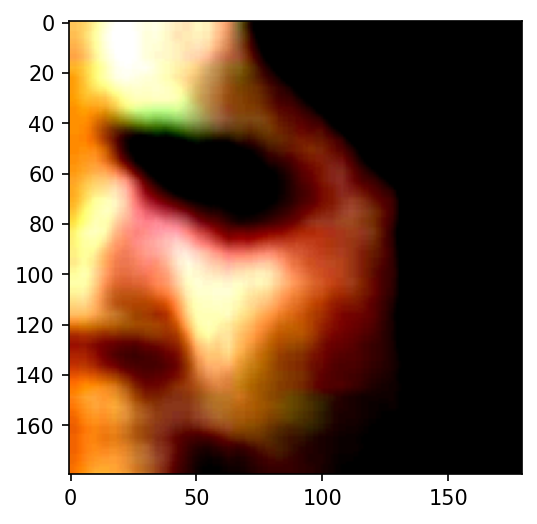

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


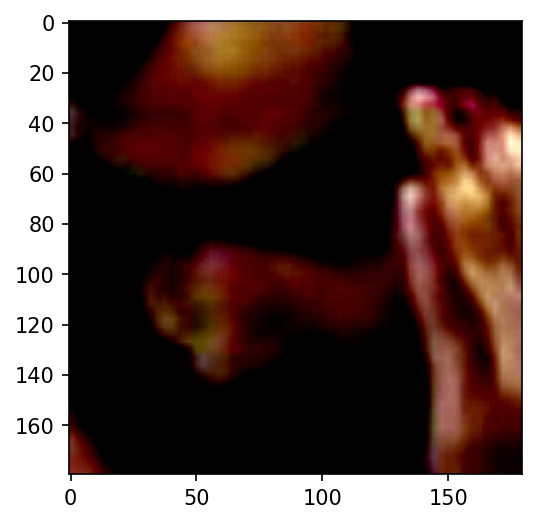

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


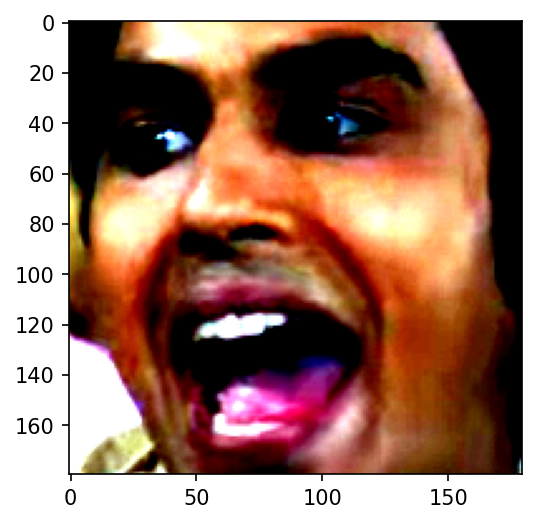

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


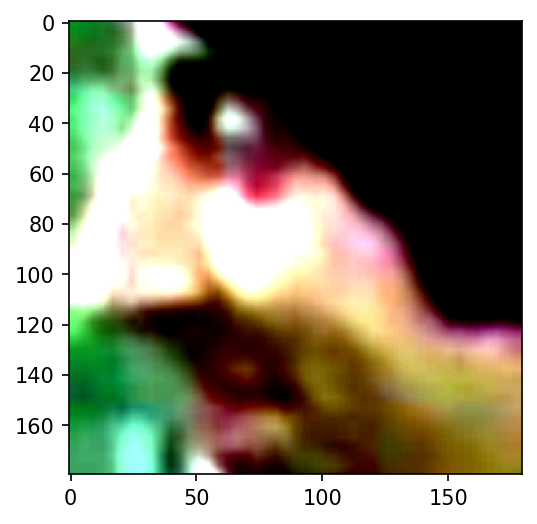

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


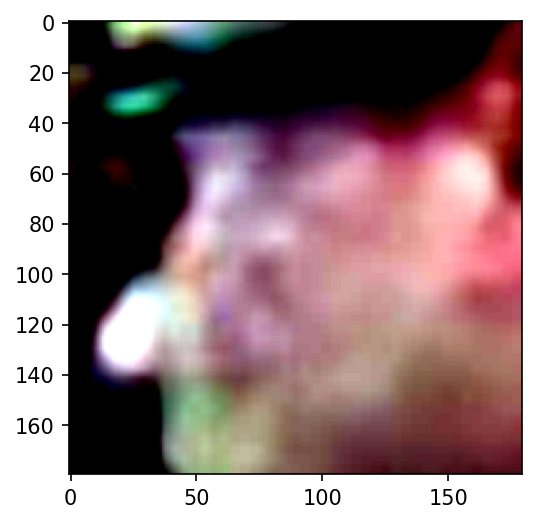

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


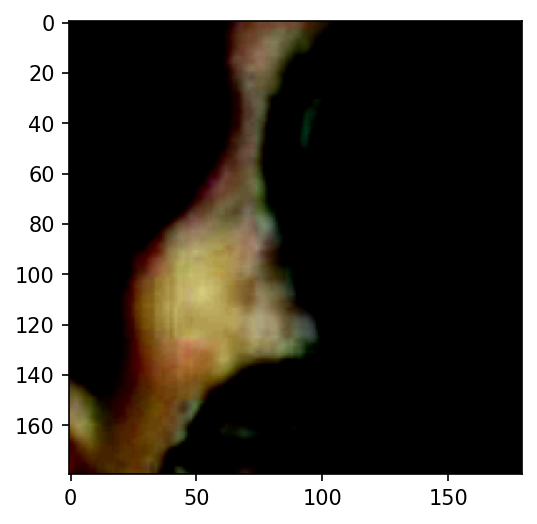

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


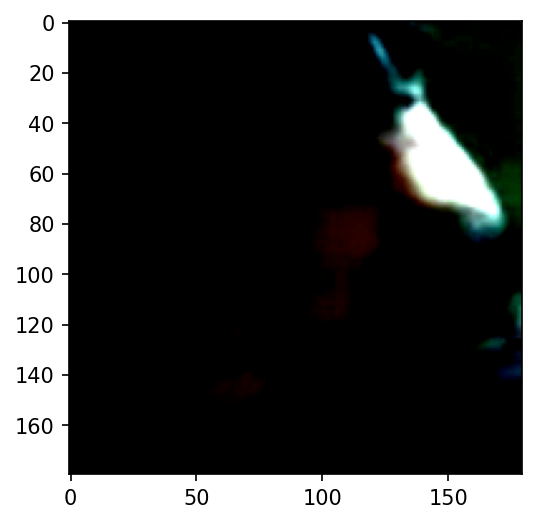

In [123]:
model.eval()
vacc, vloss = evaluate(model, valid_loader, True, loss_fnc, desired, sensitivity=True)
print (round(vacc*100, 2), vloss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


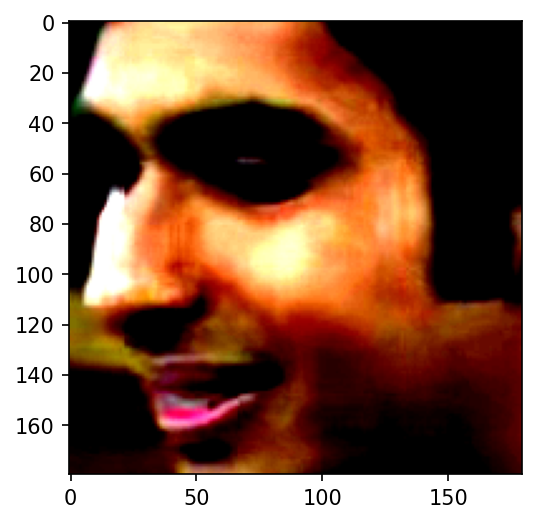

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


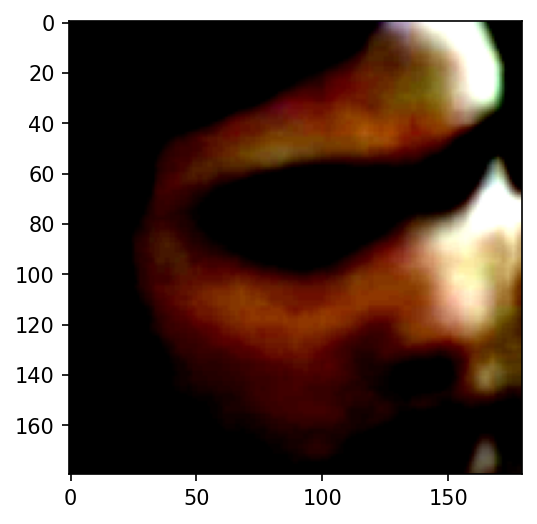

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


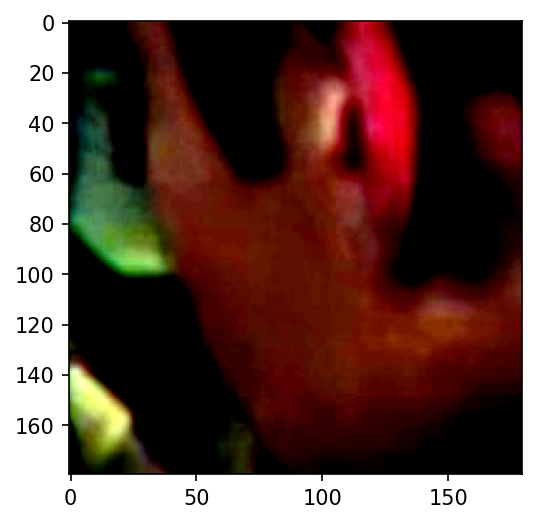

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


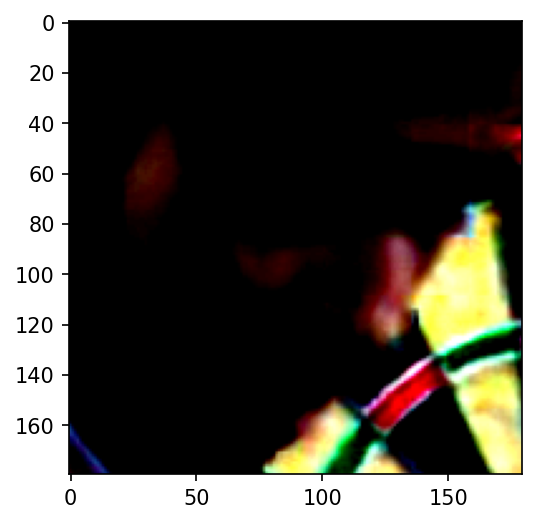

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


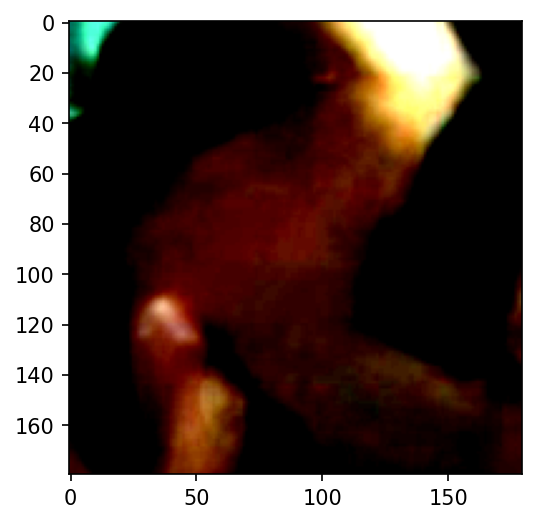

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


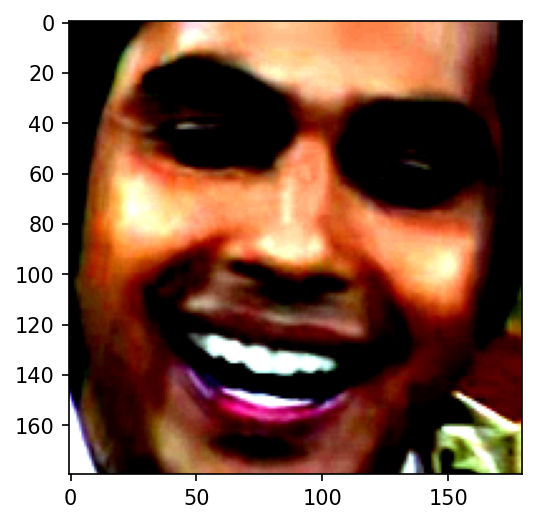

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


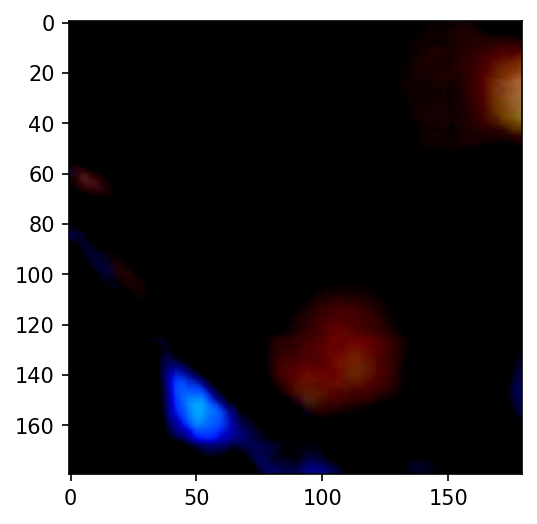

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


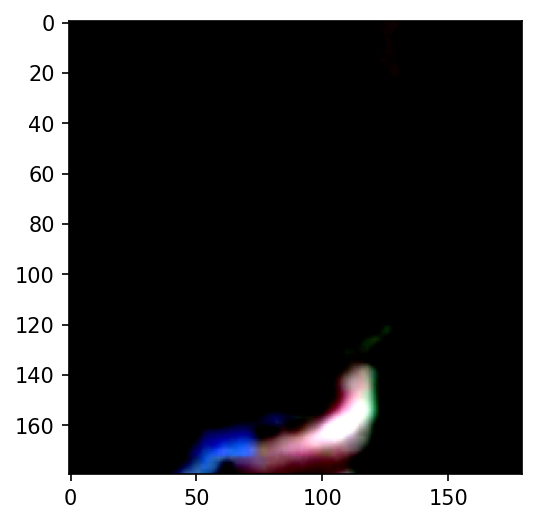

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


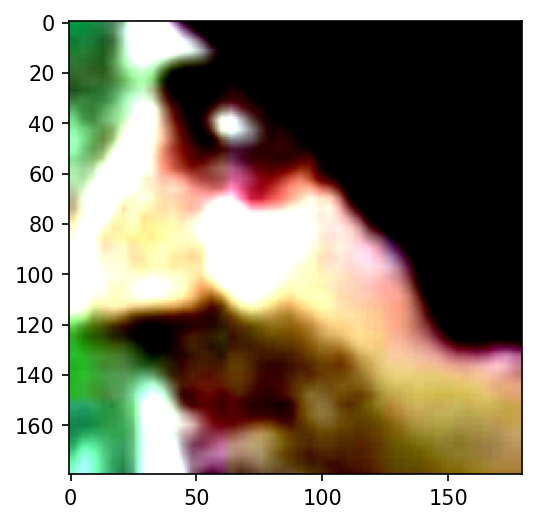

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


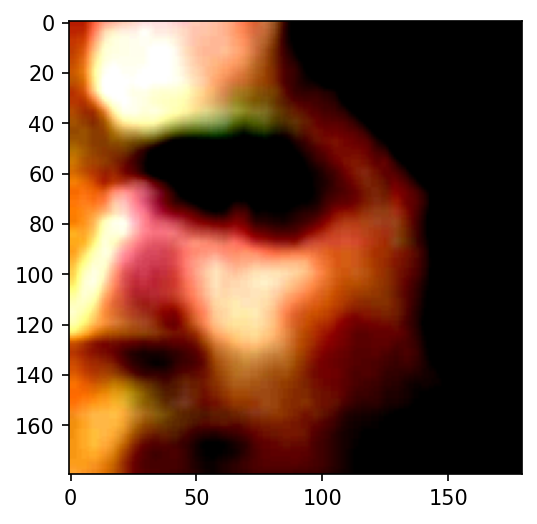

In [124]:
model.eval()
tacc, tloss = evaluate(model, test_loader, True, loss_fnc, desired, sensitivity=True) # desired
print (round(tacc*100, 2), tloss)

No hypertuning, standard models, lr=0.03 (sheldon 0.06)
~4min training time

- Leonard: 99.3% 
- Penny: 99.5%
- Raj: 99.3%
- Sheldon: 98.5%
- Wolowitz: 99.4%


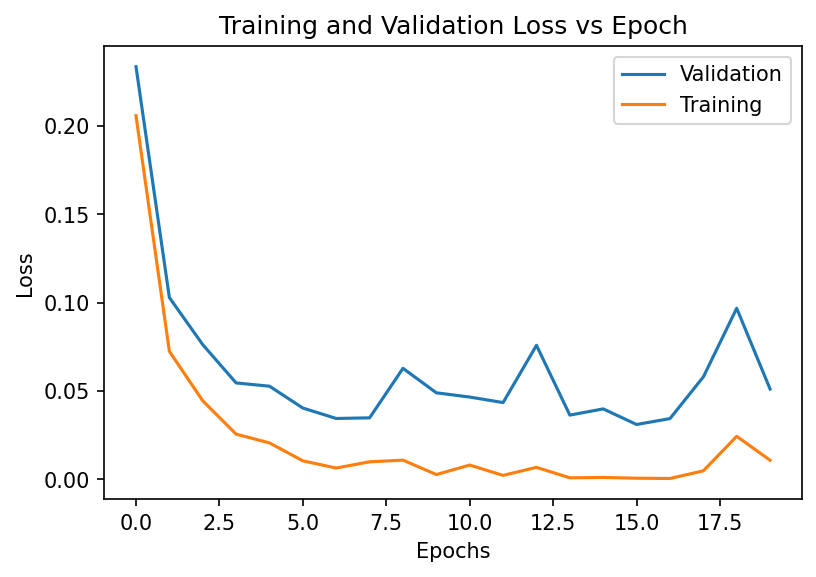

In [120]:
nRec = range(len(vlosses))
plt.plot(nRec, vlosses, label="Validation")
plt.plot(nRec, tlosses, label="Training")
plt.title("Training and Validation Loss vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Loss.jpg')
plt.show()

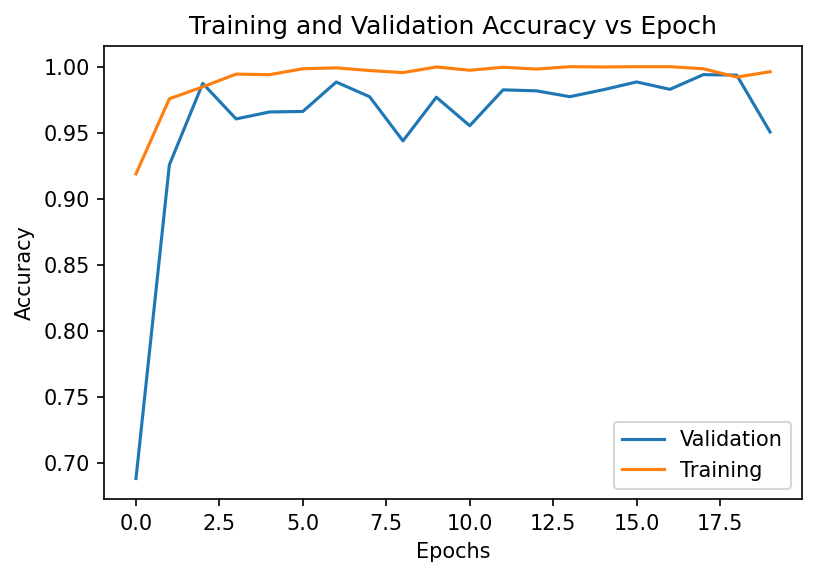

In [121]:
nRec = range(len(vaccs))
plt.plot(nRec, vaccs, label="Validation")
plt.plot(nRec, accs, label="Training")
plt.title("Training and Validation Accuracy vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy.jpg')
plt.show()

In [225]:
twos = torch.ones([6], dtype=torch.long) + 1
twos

tensor([2, 2, 2, 2, 2, 2])

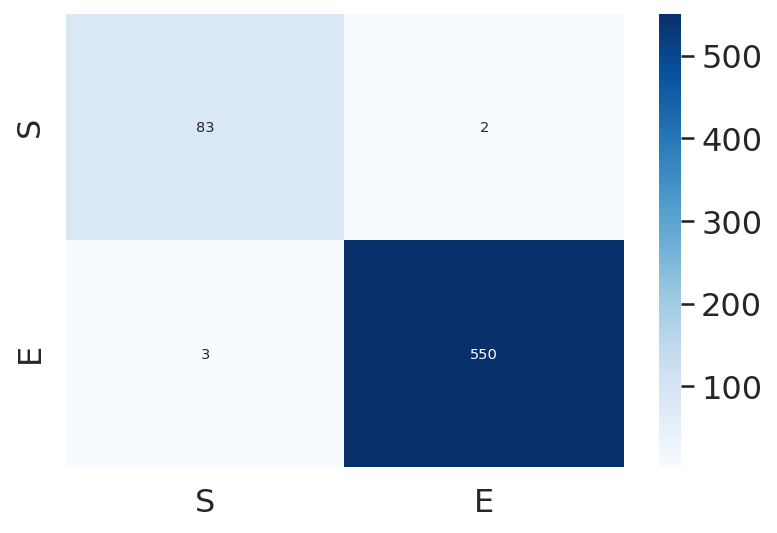

(0.9798136645962733, 0.06597181728907994)

In [155]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for data in test_loader:
        images, labels = data
        
        for i in range(len(labels)):
            y_true.append(labels[i])
        
        outputs = model(images.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred += list(predicted.float())
        
y_true = [int(c) for c in y_true]
y_pred = [int(c) for c in y_pred]

# print (y_true, y_pred)

conf_matrix = confusion_matrix(y_true, y_pred)
print (conf_matrix)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame([[83, 2],[3, 550]], index = [i for i in "SE"],
                  columns = [i for i in "SE"])


# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 7}, fmt='g', cmap="Blues") # font size
plt.savefig('Confusion.jpg')
plt.show()

evaluate(model, test_loader, False, loss_fnc)

In [13]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)

print (input, target, m(input))
output = loss(m(input), target)
output.backward()

In [51]:
ones = torch.ones([batch_size], dtype=torch.long).cuda()
neg_ones = -1 * ones
twos = ones + 1

labels    = torch.LongTensor([1,1,1,0,0,0,1,1,1]).cuda()
predicted = torch.LongTensor([1,0,1,0,1,1,1,1,1]).cuda()

# Tp should be 5

# (predicted + labels == twos[:len(labels)]).sum().item()
(predicted + labels == twos[:len(labels)]).sum().item()


5